In [5]:
from tensorflow.keras.models import load_model

loaded_model = load_model('saved_models/NVspin_GRU_model.h5')

In [6]:
import numpy as np
import random
from math import *
import cmath
from scipy.linalg import expm, fractional_matrix_power

#########################################################################

# pauli matrix 
sx = np.array([[0,  1],     [1, 0]])
sy = np.array([[0, -1j],   [1j, 0]])
sz = np.array([[1, 0],     [0, -1]])
s0 = np.array([[1, 0],      [0, 1]])

# parameters(detuning factor)
v0 = 0.02           # Arbitrary settings, Actual speed : 0.04rad/μs
d0 = 0.15           # Arbitrary settings, Actual speed : 0.30rad/μs
dt = 2.6 


# unitary operator
def unitary(dt, choice):
    
    # Select x,y-rotation direction.
    # [stay, +x, -x, +y, -y]
    choice_list = [0, 1, -1, 1, -1] 
    
    if choice < 3:
        # if choice = 0 ... only d0*sz
        Ham = (d0*sz+v0*choice_list[choice]*sx)
    else:
        Ham = (d0*sz+v0*choice_list[choice]*sy)

    # Creating a Unitary Operator for each of the four sections by Hamiltonian
    eigvals = np.linalg.eigh(Ham)[0]
    eigvecs = 1*np.linalg.eigh(Ham)[1]
    E = np.diag(eigvals)
    U_H = eigvecs.conj().T
    U_e = U_H.conj().T @ expm(-1j*E*dt) @ U_H
    
    return U_e


#########################################################################

# x-rotation operater
def Rx(theta):
    return np.matrix([  [cos(theta/2),    -1j*sin(theta/2)],
                        [-1j*sin(theta/2),    cos(theta/2)]])

# z-rotation operater
# Do not use Rz. Control by rotation only by Hamiltonian.
def Rz(phi): 
    return np.matrix([  [cos(phi/2)-1j*sin(phi/2),  0],
                        [0,  cos(phi/2)+1j*sin(phi/2)]])

# Calculating the Fidelity
def state_fidelity(rho_1, rho_2): 
    
    # rho_1(current state), rho_2(target state)
    # Calculate the fidelity after checking the dimensions of the two states.
    
    if np.shape(rho_1) != np.shape(rho_2):
            print("Dimensions of two states do not match.")
            return 0
    else:
        sqrt_rho_1 = fractional_matrix_power(rho_1, 1 / 2)
        fidelity = np.trace(fractional_matrix_power(sqrt_rho_1 @ rho_2 @ sqrt_rho_1, 1 / 2)) ** 2
        return np.real(fidelity)


#########################################################################

init_wave = np.array([[1], [0]])
irho_init = np.kron(init_wave,init_wave.conj().T)


def fidelity(target_theta, target_phi):
    
    target_U = Rz(target_phi) @ Rx(target_theta)
    irho_target = target_U @ irho_init @ target_U.conj().T

    new_theta = np.array(target_theta).reshape(-1, 1)
    new_phi = np.array(target_phi).reshape(-1, 1)
    predicted_sequence = loaded_model.predict([new_theta, new_phi])

    predicted_sequence_indices = np.argmax(predicted_sequence, axis=-1)

    Uni = s0
    U_0 = unitary(dt, 0)
    U_1 = unitary(dt, 1)
    U_2 = unitary(dt, 2)
    U_3 = unitary(dt, 3)
    U_4 = unitary(dt, 4)
    
    pulse_list = [U_0, U_1, U_2, U_3, U_4]
    
    for i in predicted_sequence_indices[0]:
        Uni = pulse_list[i] @ Uni

    irho_final = Uni @ irho_init @ Uni.conj().T
    
    F = (state_fidelity(irho_final,irho_target))
    
    return  F

In [7]:
sum = 0
iter = 10000
fidelities = []
low_fidelities = {'theta':[], 'phi':[], 'fidelity':[]}

for i in range(iter) :     
     
     target_theta = np.pi / 180 * random.uniform(0,180)
     target_phi = np.pi / 180 * random.uniform(0,360)
     
     temp = fidelity(target_theta, target_phi)
     fidelities.append(temp)
     
     if temp < 0.99:
          low_fidelities['theta'].append(target_theta)
          low_fidelities['phi'].append(target_phi)
          low_fidelities['fidelity'].append(temp)
     
     sum += temp

print(sum/iter)

1/1 [==============================] - 0s 60ms/step
0.9915324568602025


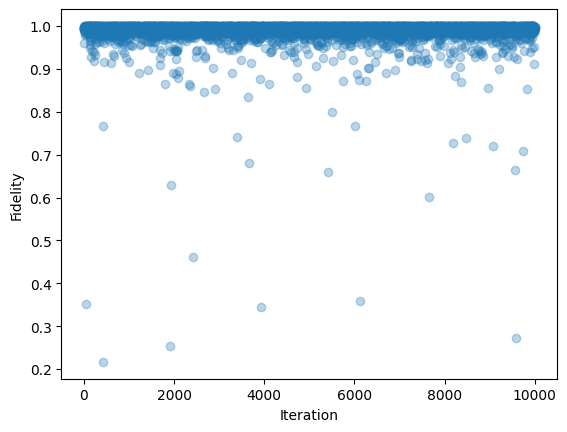

In [8]:
import matplotlib.pyplot as plt

# 그래프 표시
plt.scatter(range(iter), fidelities, alpha=0.3)
plt.xlabel('Iteration')
plt.ylabel('Fidelity')
plt.show()

In [9]:
temp = 0
sum = 0

for i in fidelities:
     temp += 1 
     if i < 0.99:
          sum += 1
          print(temp, i)

print(sum)
print(np.std(fidelities))
print(min(fidelities))

4 0.9886044588400529
9 0.9612940428009439
19 0.979135832043912
22 0.9804707984311495
25 0.9867046315547207
38 0.989998614729911
50 0.9884922919667188
60 0.35146388832419534
62 0.9843736162752286
74 0.9886752716125508
76 0.9808175031947327
79 0.9891766070525438
87 0.9894742640334838
90 0.9821749097636965
116 0.9886365925199313
119 0.981201340001009
122 0.9896869275042969
127 0.9564465659660862
128 0.9658464950046975
130 0.9736901954036619
134 0.985432340726465
137 0.9480718580744313
150 0.9736273598833907
151 0.9811916116370926
152 0.9278543862396874
160 0.989461145431401
161 0.9681650420220155
177 0.9805732492413314
181 0.9414046965563682
182 0.9891384403605943
184 0.9884229242552369
188 0.9873550267961323
189 0.9893363746269596
192 0.9882547042588251
194 0.9858068789788319
201 0.9872336612727596
210 0.9873826477545021
214 0.9835630455145524
221 0.9381246883251019
233 0.9728184013241018
234 0.9185965994290862
239 0.9571071246391797
252 0.9317824720278487
259 0.9881187656592126
260 0.97

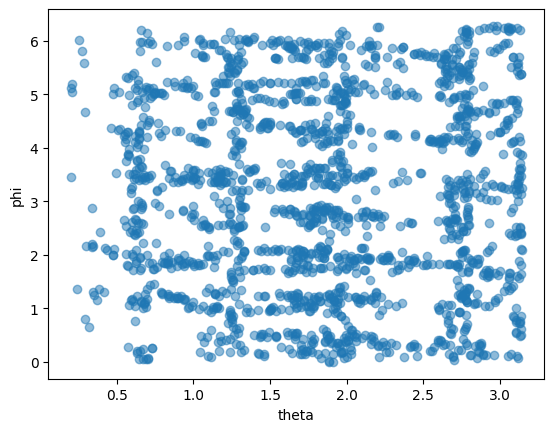

In [10]:
import matplotlib.pyplot as plt

# 그래프 표시
plt.scatter(low_fidelities['theta'], low_fidelities['phi'], alpha=0.5)
plt.xlabel('theta')
plt.ylabel('phi')
plt.show()

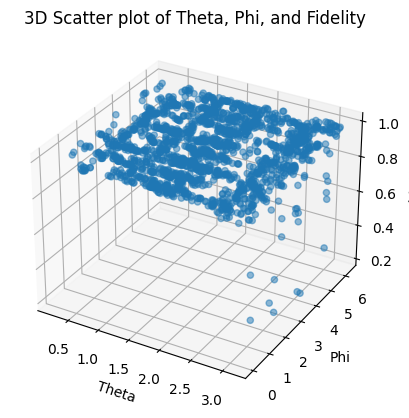

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 3차원 그래프 생성
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(low_fidelities['theta'], low_fidelities['phi'], low_fidelities['fidelity'], alpha=0.5)
ax.set_xlabel('Theta')
ax.set_ylabel('Phi')
ax.set_zlabel('Fidelity')
plt.title('3D Scatter plot of Theta, Phi, and Fidelity')
plt.show()
